In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [3]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=35

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

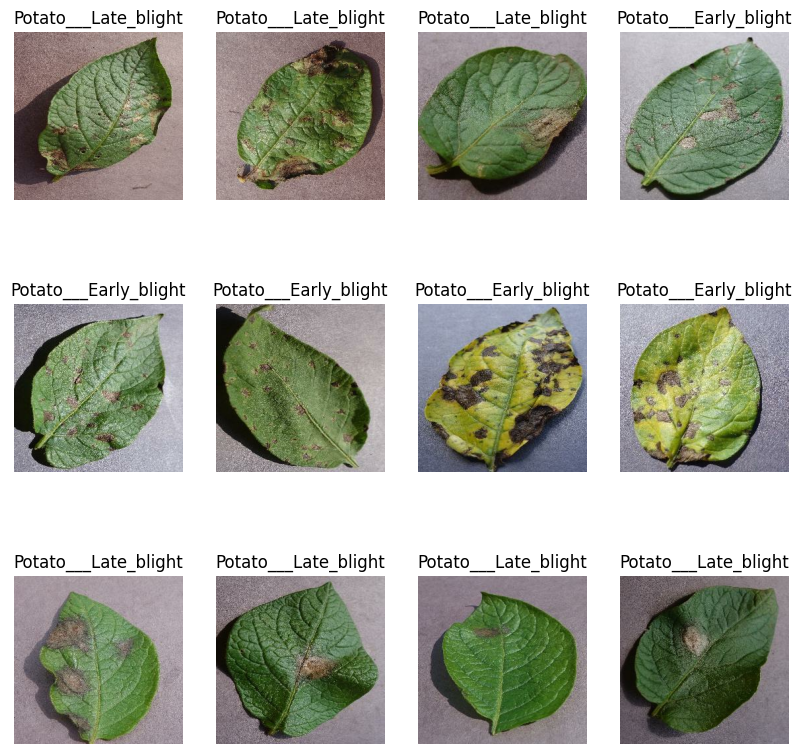

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
len(dataset)

68

In [9]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

In [10]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds= dataset.take(54)
len(train_ds)

54

In [12]:
test_ds= dataset.skip(54)
len(test_ds)

14

In [13]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

54

In [19]:
len(val_ds)

6

In [20]:
len(test_ds)

8

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])


In [23]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2),
  # layers.experimental.preprocessing.RandomContrast(0.2),
])

 # tf.keras.layers.RandomFlip("horizontal_and_vertical"),
 #    tf.keras.layers.RandomRotation(0.2),
 #    tf.keras.layers.RandomZoom(0.2),
 #    tf.keras.layers.RandomContrast(0.2),

In [24]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [28]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/35
54/54 [==============================] - 181s 3s/step - loss: 0.9109 - accuracy: 0.4902 - val_loss: 0.8527 - val_accuracy: 0.6771
Epoch 2/35
54/54 [==============================] - 88s 2s/step - loss: 0.6917 - accuracy: 0.6950 - val_loss: 0.4855 - val_accuracy: 0.7760
Epoch 3/35
54/54 [==============================] - 94s 2s/step - loss: 0.5585 - accuracy: 0.7564 - val_loss: 0.4057 - val_accuracy: 0.8073
Epoch 4/35
54/54 [==============================] - 101s 2s/step - loss: 0.4307 - accuracy: 0.8061 - val_loss: 0.3763 - val_accuracy: 0.8281
Epoch 5/35
54/54 [==============================] - 106s 2s/step - loss: 0.3105 - accuracy: 0.8600 - val_loss: 0.2490 - val_accuracy: 0.8958
Epoch 6/35
54/54 [==============================] - 96s 2s/step - loss: 0.2579 - accuracy: 0.8981 - val_loss: 0.2797 - val_accuracy: 0.9115
Epoch 7/35
54/54 [==============================] - 94s 2s/step - loss: 0.2764 - accuracy: 0.8889 - val_loss: 0.2264 - val_accuracy: 0.9167
Epoch 8/35
54/54 

In [29]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 6s 375ms/step - loss: 0.0658 - accuracy: 0.9766


In [30]:
scores

[0.0658397302031517, 0.9765625]

In [31]:
history

In [32]:
history.params

{'verbose': 1, 'epochs': 35, 'steps': 54}

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
history.history['accuracy']

[0.49016204476356506,
 0.6950231194496155,
 0.7563657164573669,
 0.8061342835426331,
 0.8599537014961243,
 0.8981481194496155,
 0.8888888955116272,
 0.9126157164573669,
 0.9328703880310059,
 0.9178240895271301,
 0.921875,
 0.9369212985038757,
 0.9467592835426331,
 0.9565972089767456,
 0.9606481194496155,
 0.9699074029922485,
 0.9716435074806213,
 0.9785879850387573,
 0.9612268805503845,
 0.9826388955116272,
 0.9756944179534912,
 0.9722222089767456,
 0.9785879850387573,
 0.9814814925193787,
 0.9820601940155029,
 0.9809027910232544,
 0.9716435074806213,
 0.9803240895271301,
 0.9832175970077515,
 0.9849537014961243,
 0.9866898059844971,
 0.9780092835426331,
 0.9878472089767456,
 0.9780092835426331,
 0.9809027910232544]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Traning and Validation LOSS')

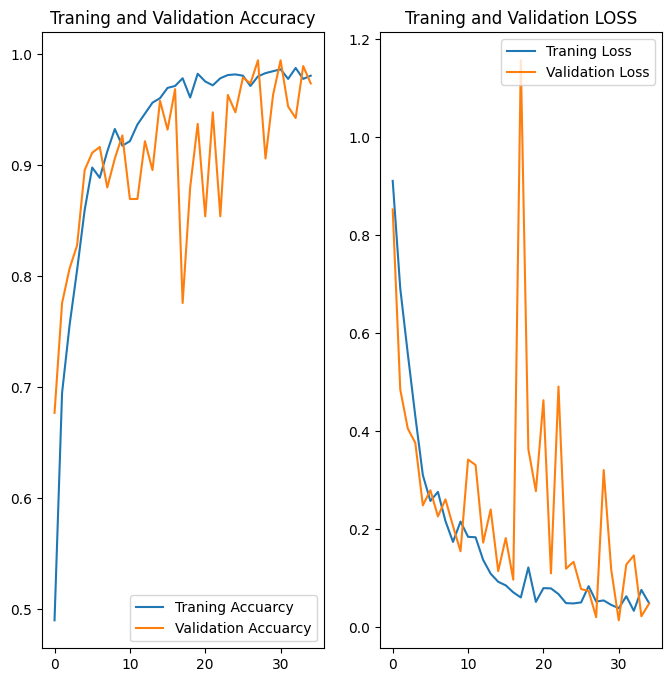

In [36]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Traning Accuarcy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuarcy')
plt.legend(loc = 'lower right')
plt.title('Traning and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Traning Loss')
plt.plot(range(EPOCHS), val_loss , label='Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Traning and Validation LOSS')

first image to predict
first image's actual label: Potato___Early_blight
1/1 [==============================] - 1s 701ms/step
predicted label: Potato___Early_blight


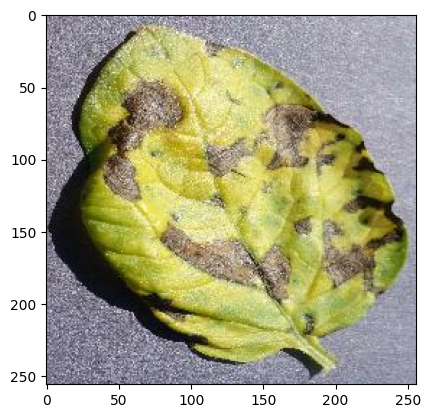

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label =labels_batch[0]
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:" ,class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy()) 
    img_array = tf.expand_dims (img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)

    predicted_class = class_names [np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class , confidence

1/1 [==============================] - 0s 37ms/step


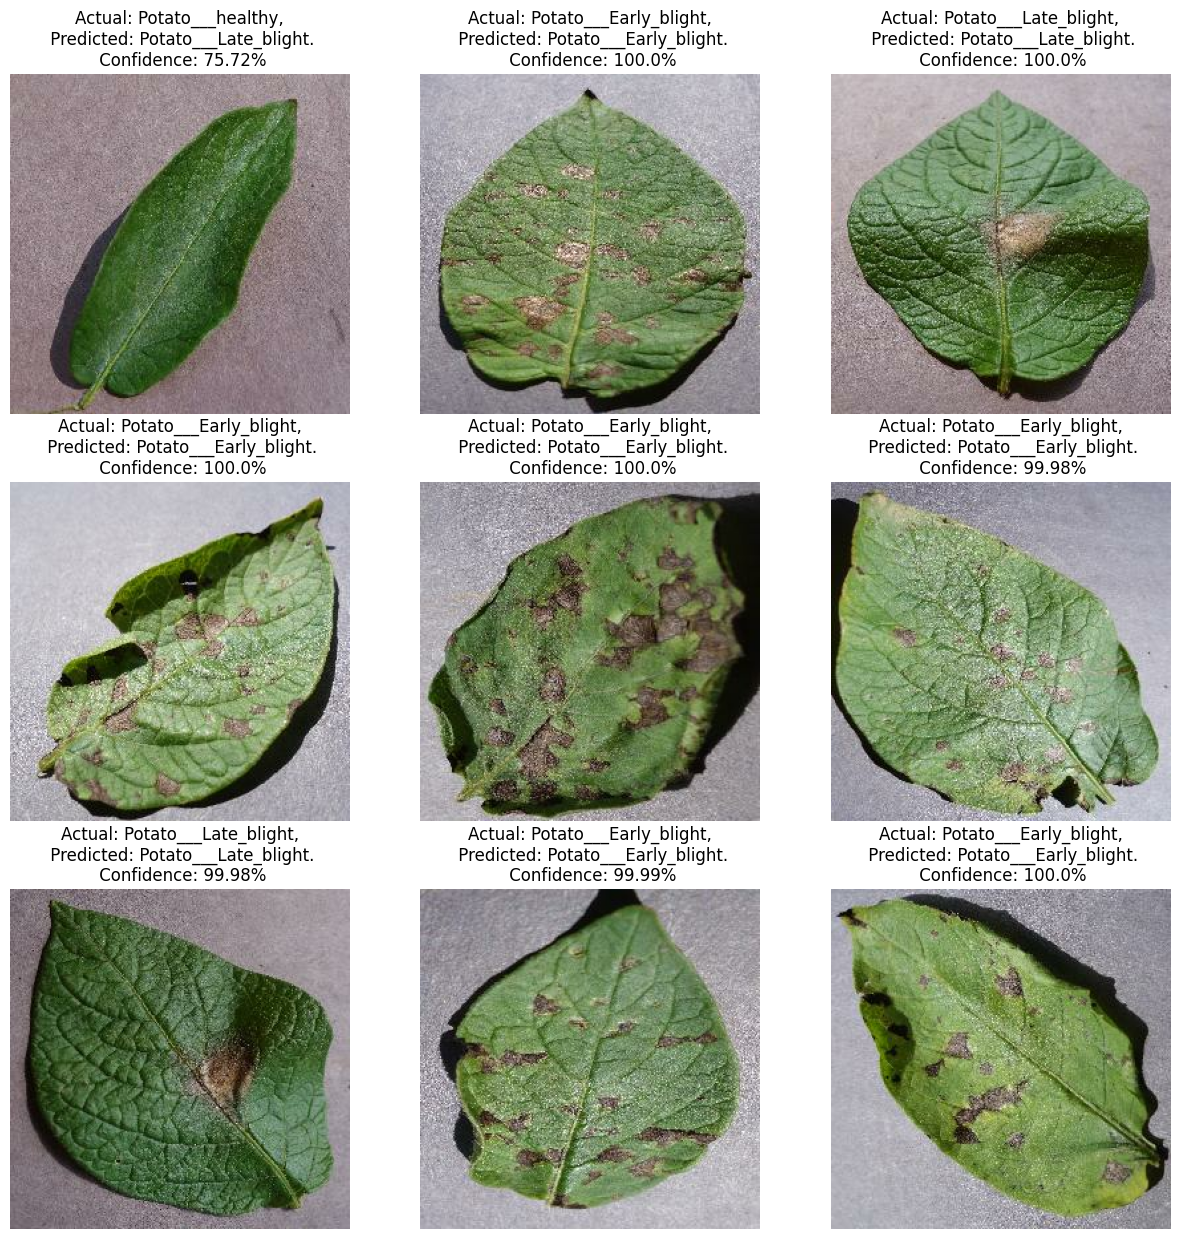

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [40]:
import os
model_files = os.listdir("../saved_models")
model_versions = [int(i.split('.')[0]) for i in model_files if i.endswith('.keras')]

# If there are no existing models, start with version 1
new_model_version = max(model_versions, default=0) + 1
model.save(f"../saved_models/{new_model_version}.keras")